# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/github/WilliamJWen/APS360/blob/main/lab/Lab5_Spam_Detection.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cp /content/drive/MyDrive/APS360/lab5/sms+spam+collection/SMSSpamCollection .

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
# spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
# ham	U dun say so early hor... U c already then say...

for line in open('SMSSpamCollection'):
  first_word = line.split()[0]
  if first_word == 'spam':
    print(line)
    break

for line in open('SMSSpamCollection'):
  first_word = line.split()[0]
  if first_word == 'ham':
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



**Answer:**
- The label value for a spam message is "spam".
- The label value for a non-spam message is "ham".

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam_count = 0
ham_count = 0
for line in open('SMSSpamCollection'):
  first_word = line.split()[0]
  if first_word == 'spam':
    spam_count += 1
  elif first_word == 'ham':
    ham_count += 1
print(f'There are {spam_count} spam messages in the data set.')
print(f'There are {ham_count} non-spam messages in the data set.')

There are 747 spam messages in the data set.
There are 4827 non-spam messages in the data set.


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [6]:
import string
characters = list(string.ascii_letters + string.digits + string.punctuation + ' ')
print(characters)
stoi = {'padding': 0}
itos = {0: 'padding'}
for idx, char in enumerate(characters):
  stoi[char] = idx + 1
  itos[idx + 1] = char
print(stoi)
print(itos)


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']
{'padding': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '0': 53, '1': 54, '2': 55, '3': 56, '4': 57, '5':

In [7]:
sequences = []
labels = []

for line in open('SMSSpamCollection'):
  line = line.strip() # remove '\n' and trailing white spaces
  label, sentence = line.split('\t')

  if label == 'ham':
    labels.append(0)
  elif label == 'spam':
    labels.append(1)
  else:
    raise ValueError(f'Unknown label: {label}')
  sequence = []
  for char in sentence:
    if char not in stoi:
      stoi[char] = len(stoi)
      itos[len(itos)] = char
    sequence.append(stoi[char])
  sequences.append(sequence)
print(labels[:5])
print(sequences[:5])

[0, 0, 1, 0, 0]
[[33, 15, 95, 21, 14, 20, 9, 12, 95, 10, 21, 18, 15, 14, 7, 95, 16, 15, 9, 14, 20, 74, 95, 3, 18, 1, 26, 25, 76, 76, 95, 27, 22, 1, 9, 12, 1, 2, 12, 5, 95, 15, 14, 12, 25, 95, 9, 14, 95, 2, 21, 7, 9, 19, 95, 14, 95, 7, 18, 5, 1, 20, 95, 23, 15, 18, 12, 4, 95, 12, 1, 95, 5, 95, 2, 21, 6, 6, 5, 20, 76, 76, 76, 95, 29, 9, 14, 5, 95, 20, 8, 5, 18, 5, 95, 7, 15, 20, 95, 1, 13, 15, 18, 5, 95, 23, 1, 20, 76, 76, 76], [41, 11, 95, 12, 1, 18, 76, 76, 76, 95, 36, 15, 11, 9, 14, 7, 95, 23, 9, 6, 95, 21, 95, 15, 14, 9, 76, 76, 76], [32, 18, 5, 5, 95, 5, 14, 20, 18, 25, 95, 9, 14, 95, 55, 95, 1, 95, 23, 11, 12, 25, 95, 3, 15, 13, 16, 95, 20, 15, 95, 23, 9, 14, 95, 32, 27, 95, 29, 21, 16, 95, 6, 9, 14, 1, 12, 95, 20, 11, 20, 19, 95, 55, 54, 19, 20, 95, 39, 1, 25, 95, 55, 53, 53, 58, 76, 95, 46, 5, 24, 20, 95, 32, 27, 95, 20, 15, 95, 61, 60, 54, 55, 54, 95, 20, 15, 95, 18, 5, 3, 5, 9, 22, 5, 95, 5, 14, 20, 18, 25, 95, 17, 21, 5, 19, 20, 9, 15, 14, 70, 19, 20, 4, 95, 20, 24, 20, 95, 18

### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [8]:
from sklearn.model_selection import train_test_split
indices = list(range(len(sequences)))
train_index, temp_index = train_test_split(
    indices, test_size=0.4, random_state=42, stratify=labels)
val_index, test_index = train_test_split(
    temp_index, test_size=0.5, random_state=42, stratify=[labels[i] for i in temp_index] )

# x: sequences, y: labels
train_x = [sequences[idx] for idx in train_index]
train_y = [labels[idx] for idx in train_index]
val_x = [sequences[idx] for idx in val_index]
val_y = [labels[idx] for idx in val_index]
test_x = [sequences[idx] for idx in test_index]
test_y = [labels[idx] for idx in test_index]

#Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [9]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_sequences(batch):
  sequences, labels = zip(*batch)
  sequences = [torch.tensor(seq) for seq in sequences]
  padded_sequences = pad_sequence(sequences, batch_first=True)
  labels = torch.tensor(labels)

  return padded_sequences, labels

train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

In [10]:
for batch_idx, bach in enumerate(train_loader):
  print(bach)
  print(bach[0].shape)
  print(bach[1].shape)
  break

(tensor([[28, 21, 26,  ...,  0,  0,  0],
        [47, 19,  6,  ...,  0,  0,  0],
        [51, 15, 21,  ...,  0,  0,  0],
        ...,
        [47, 14,  4,  ...,  0,  0,  0],
        [27,  9,  7,  ...,  0,  0,  0],
        [30, 15, 95,  ...,  0,  0,  0]]), tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1]))
torch.Size([32, 165])
torch.Size([32])


### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [11]:
for idx, batch in enumerate(train_loader):
    if idx == 10:
        break
    print(batch)
    print(f'batch {idx} has maximum length of the input sequence of {batch[0].shape[1]}')
    print(f'batch {idx} used {torch.sum(batch[0]==0)} <pad> tokens.')
    print()

(tensor([[35, 95, 20,  ...,  0,  0,  0],
        [58, 53, 53,  ...,  0,  0,  0],
        [41, 95, 23,  ...,  0,  0,  0],
        ...,
        [34,  1, 22,  ...,  0,  0,  0],
        [30,  5,  1,  ...,  0,  0,  0],
        [49,  9, 14,  ...,  0,  0,  0]]), tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1]))
batch 0 has maximum length of the input sequence of 161
batch 0 used 1822 <pad> tokens.

(tensor([[46,  8,  5,  ...,  0,  0,  0],
        [40, 15, 16,  ...,  0,  0,  0],
        [35, 95,  4,  ...,  0,  0,  0],
        ...,
        [32, 18,  5,  ...,  0,  0,  0],
        [32, 18,  5,  ...,  0,  0,  0],
        [28,  5,  1,  ...,  0,  0,  0]]), tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0]))
batch 1 has maximum length of the input sequence of 192
batch 1 used 2564 <pad> tokens.

(tensor([[34, 27, 42,  ...,  0,  0,  0],
        [38,  1, 19,  ...,  0,  0,  0],
 

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [12]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [13]:
class SpamDetector(nn.Module):
  def __init__(self, vocab_size, hidden_size=64, n_layers=1):
    super(SpamDetector, self).__init__()

    self.hidden_size = hidden_size
    self.n_layers = n_layers

    # identity matrix for generating one-hot vectors
    self.ident = torch.eye(vocab_size)

    self.rnn = nn.RNN(
        input_size = vocab_size,
        hidden_size = hidden_size,
        num_layers = n_layers,
        batch_first=True
    )

    # a fully connected layer that outputs one neuron
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    # Get One Hot Encoding
    # this works element-wise
    # replacing indices in x with corresponding row in identity matrix
    x = self.ident[x]

    # set an intial hidden space (this is okay for classification problem)
    # [num_layers * num_directions, batch_size, hidden_space]
    h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device) #an initial hidden state
    out, hn = self.rnn(x, h0)

    # Linear Layer
    output = self.fc(out[:, -1, :])

    return output.squeeze(1)

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [14]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
      for batch_x, batch_y in data:

        logits = model(batch_x)
        preds = (torch.sigmoid(logits) > 0.5).long()

        correct += torch.sum(preds == batch_y).item()
        total += len(batch_y)

    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [15]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    epochs = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_samples = 0

        for batch_x, batch_y in train_loader:
            batch_y = batch_y.float()
            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_y.size(0)
            total_samples += batch_y.size(0)

        avg_train_loss = total_loss / total_samples
        train_losses.append(avg_train_loss)
        train_accs.append(get_accuracy(model, train_loader))

        # === Validation loss ===
        model.eval()
        val_loss_total, val_samples = 0, 0
        with torch.no_grad():
          for val_x, val_y in valid_loader:
            val_y = val_y.float()
            logits = model(val_x)
            val_loss = criterion(logits, val_y)
            val_loss_total += val_loss.item() * val_y.size(0)
            val_samples += val_y.size(0)
        avg_val_loss = val_loss_total / val_samples
        valid_losses.append(avg_val_loss)
        valid_accs.append(get_accuracy(model, valid_loader))

        epochs.append(epoch)

        print(f"Epoch {epoch+1}:"
              f"Train Loss={avg_train_loss:.4f}, Train Acc={train_accs[-1]:.4f},"
              f"Val Acc={valid_accs[-1]:.4f}, Val Loss={avg_val_loss:.4f}")

    # 📈 Plot Loss Curve
    plt.title("Loss Curve")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # 📈 Plot Accuracy Curve
    plt.title("Accuracy Curve")
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, valid_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Epoch 1:Train Loss=0.6926, Train Acc=0.5191,Val Acc=0.1372, Val Loss=0.7220
Epoch 2:Train Loss=0.6917, Train Acc=0.5232,Val Acc=0.1417, Val Loss=0.7036
Epoch 3:Train Loss=0.6696, Train Acc=0.7536,Val Acc=0.8296, Val Loss=0.5177
Epoch 4:Train Loss=0.6368, Train Acc=0.6988,Val Acc=0.8565, Val Loss=0.5529
Epoch 5:Train Loss=0.6736, Train Acc=0.5199,Val Acc=0.1345, Val Loss=1.0094
Epoch 6:Train Loss=0.7067, Train Acc=0.5201,Val Acc=0.1345, Val Loss=0.7916
Epoch 7:Train Loss=0.6770, Train Acc=0.7291,Val Acc=0.8493, Val Loss=0.5936
Epoch 8:Train Loss=0.6741, Train Acc=0.5209,Val Acc=0.1354, Val Loss=0.8259
Epoch 9:Train Loss=0.6171, Train Acc=0.5209,Val Acc=0.1354, Val Loss=1.0553
Epoch 10:Train Loss=0.6475, Train Acc=0.7424,Val Acc=0.8117, Val Loss=0.4996
Epoch 11:Train Loss=0.5841, Train Acc=0.7364,Val Acc=0.8511, Val Loss=0.4556
Epoch 12:Train Loss=0.6334, Train Acc=0.5216,Val Acc=0.1390, Val Loss=1.0883
Epoch 13:Train Loss=0.6308, Train Acc=0.7414,Val Acc=0.8404, Val Loss=0.4847
Epoch 14

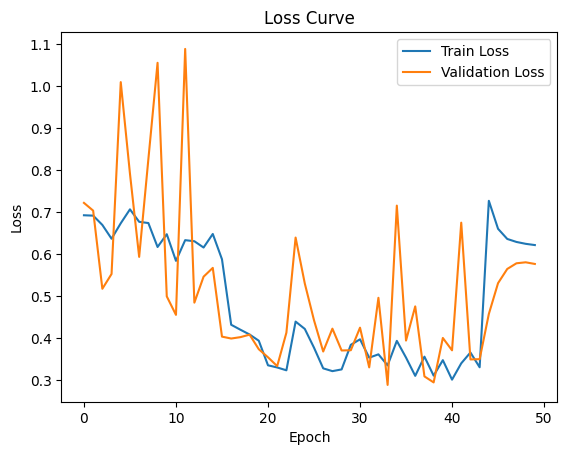

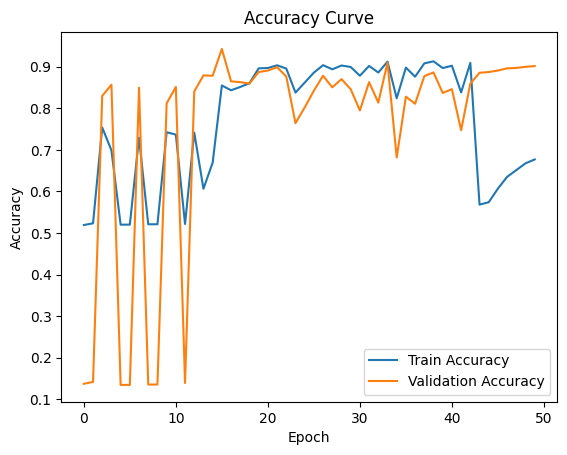

In [16]:
model = SpamDetector(len(stoi))
train_rnn_network(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1:Train Loss=0.6862, Train Acc=0.5254,Val Acc=0.1408, Val Loss=0.7058
Epoch 2:Train Loss=0.6271, Train Acc=0.9035,Val Acc=0.9498, Val Loss=0.5672
Epoch 3:Train Loss=0.5095, Train Acc=0.9251,Val Acc=0.9587, Val Loss=0.4769
Epoch 4:Train Loss=0.4192, Train Acc=0.9234,Val Acc=0.9704, Val Loss=0.3871
Epoch 5:Train Loss=0.3584, Train Acc=0.9325,Val Acc=0.9489, Val Loss=0.3750
Epoch 6:Train Loss=0.3047, Train Acc=0.9406,Val Acc=0.9507, Val Loss=0.3155
Epoch 7:Train Loss=0.2810, Train Acc=0.9269,Val Acc=0.9722, Val Loss=0.2504
Epoch 8:Train Loss=0.2462, Train Acc=0.9524,Val Acc=0.9605, Val Loss=0.2450
Epoch 9:Train Loss=0.2450, Train Acc=0.9348,Val Acc=0.9677, Val Loss=0.2286
Epoch 10:Train Loss=0.2178, Train Acc=0.9561,Val Acc=0.9650, Val Loss=0.2104
Epoch 11:Train Loss=0.2082, Train Acc=0.9431,Val Acc=0.9758, Val Loss=0.1755
Epoch 12:Train Loss=0.1865, Train Acc=0.9526,Val Acc=0.9471, Val Loss=0.2081
Epoch 13:Train Loss=0.1748, Train Acc=0.9400,Val Acc=0.9300, Val Loss=0.2297
Epoch 14

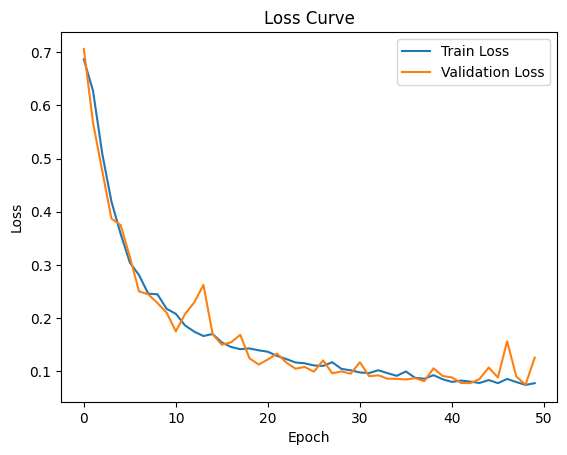

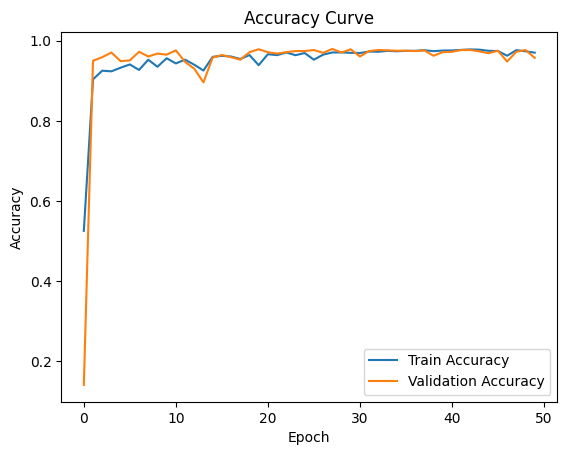

In [20]:
# Max-Pool over output array
# Max Pool is suggested by the notebook and capture salient features
class MaxPoolSpamDetector(nn.Module):
  def __init__(self, vocab_size, hidden_size=64, n_layers=1):
    super(MaxPoolSpamDetector, self).__init__()

    self.hidden_size = hidden_size
    self.n_layers = n_layers

    # identity matrix for generating one-hot vectors
    self.ident = torch.eye(vocab_size)

    self.rnn = nn.RNN(
        input_size = vocab_size,
        hidden_size = hidden_size,
        num_layers = n_layers,
        batch_first=True
    )

    # a fully connected layer that outputs one neuron
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    # Get One Hot Encoding
    # this works element-wise
    # replacing indices in x with corresponding row in identity matrix
    x = self.ident[x]

    # set an intial hidden space (this is okay for classification problem)
    # [num_layers * num_directions, batch_size, hidden_space]
    h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device) #an initial hidden state
    out, hn = self.rnn(x, h0)

    # Linear Layer applied on maxpool
    output = self.fc(torch.max(out, dim=1)[0])

    return output.squeeze(1)
maxpool_model = MaxPoolSpamDetector(len(stoi))
train_rnn_network(maxpool_model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4)

Epoch 1:Train Loss=0.6632, Train Acc=0.7725,Val Acc=0.7247, Val Loss=0.6320
Epoch 2:Train Loss=0.4715, Train Acc=0.7959,Val Acc=0.7874, Val Loss=0.5363
Epoch 3:Train Loss=0.5123, Train Acc=0.5542,Val Acc=0.8861, Val Loss=0.3486
Epoch 4:Train Loss=0.4006, Train Acc=0.9040,Val Acc=0.8978, Val Loss=0.3848
Epoch 5:Train Loss=0.3091, Train Acc=0.9161,Val Acc=0.9336, Val Loss=0.2744
Epoch 6:Train Loss=0.2687, Train Acc=0.9241,Val Acc=0.9516, Val Loss=0.2223
Epoch 7:Train Loss=0.2349, Train Acc=0.9300,Val Acc=0.9426, Val Loss=0.2226
Epoch 8:Train Loss=0.2171, Train Acc=0.9370,Val Acc=0.9534, Val Loss=0.1871
Epoch 9:Train Loss=0.1984, Train Acc=0.9392,Val Acc=0.9435, Val Loss=0.2028
Epoch 10:Train Loss=0.1863, Train Acc=0.9352,Val Acc=0.9444, Val Loss=0.1884
Epoch 11:Train Loss=0.1750, Train Acc=0.9501,Val Acc=0.9614, Val Loss=0.1456
Epoch 12:Train Loss=0.1614, Train Acc=0.9499,Val Acc=0.9704, Val Loss=0.1215
Epoch 13:Train Loss=0.1584, Train Acc=0.9567,Val Acc=0.9668, Val Loss=0.1303
Epoch 14

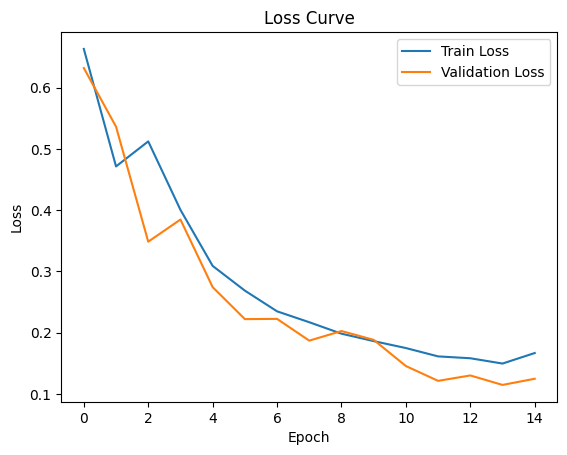

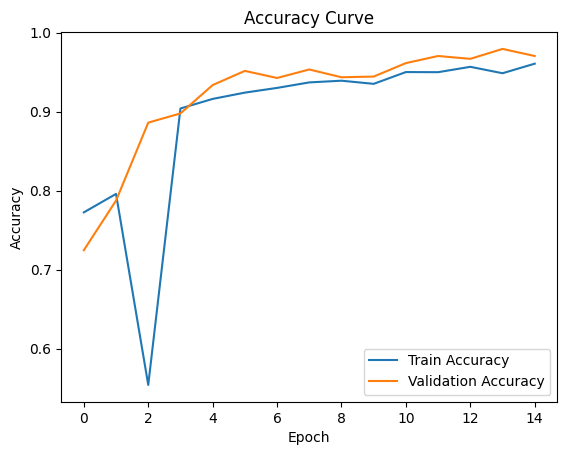

In [23]:
# Max-Pool Concate Avg Pool over output array
class MCASpamDetector(nn.Module):
  def __init__(self, vocab_size, hidden_size=64, n_layers=1):
    super(MCASpamDetector, self).__init__()

    self.hidden_size = hidden_size
    self.n_layers = n_layers

    # identity matrix for generating one-hot vectors
    self.ident = torch.eye(vocab_size)

    self.rnn = nn.RNN(
        input_size = vocab_size,
        hidden_size = hidden_size,
        num_layers = n_layers,
        batch_first=True
    )

    # a fully connected layer that outputs one neuron
    self.fc = nn.Linear(2 * hidden_size, 1)

  def forward(self, x):
    # Get One Hot Encoding
    # this works element-wise
    # replacing indices in x with corresponding row in identity matrix
    x = self.ident[x]

    # set an intial hidden space (this is okay for classification problem)
    # [num_layers * num_directions, batch_size, hidden_space]
    h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device) #an initial hidden state
    out, hn = self.rnn(x, h0)
    out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)

    # Linear Layer applied on maxpool
    output = self.fc(out)

    return output.squeeze(1)
mca_model = MCASpamDetector(len(stoi))
train_rnn_network(mca_model, train_loader, val_loader, num_epochs=15, learning_rate=1e-4)

Epoch 1:Train Loss=0.6354, Train Acc=0.7881,Val Acc=0.8161, Val Loss=0.4862
Epoch 2:Train Loss=0.4641, Train Acc=0.8286,Val Acc=0.8960, Val Loss=0.2957
Epoch 3:Train Loss=0.3166, Train Acc=0.9040,Val Acc=0.9157, Val Loss=0.2698
Epoch 4:Train Loss=0.2336, Train Acc=0.9373,Val Acc=0.9453, Val Loss=0.1966
Epoch 5:Train Loss=0.2011, Train Acc=0.9493,Val Acc=0.9552, Val Loss=0.1824
Epoch 6:Train Loss=0.1767, Train Acc=0.9438,Val Acc=0.9354, Val Loss=0.2249
Epoch 7:Train Loss=0.1650, Train Acc=0.9567,Val Acc=0.9641, Val Loss=0.1429
Epoch 8:Train Loss=0.1458, Train Acc=0.9392,Val Acc=0.9749, Val Loss=0.0936
Epoch 9:Train Loss=0.1339, Train Acc=0.9624,Val Acc=0.9713, Val Loss=0.1042
Epoch 10:Train Loss=0.1314, Train Acc=0.9695,Val Acc=0.9722, Val Loss=0.1034
Epoch 11:Train Loss=0.1177, Train Acc=0.9667,Val Acc=0.9767, Val Loss=0.0851
Epoch 12:Train Loss=0.1125, Train Acc=0.9680,Val Acc=0.9776, Val Loss=0.0860
Epoch 13:Train Loss=0.1120, Train Acc=0.9657,Val Acc=0.9677, Val Loss=0.1211
Epoch 14

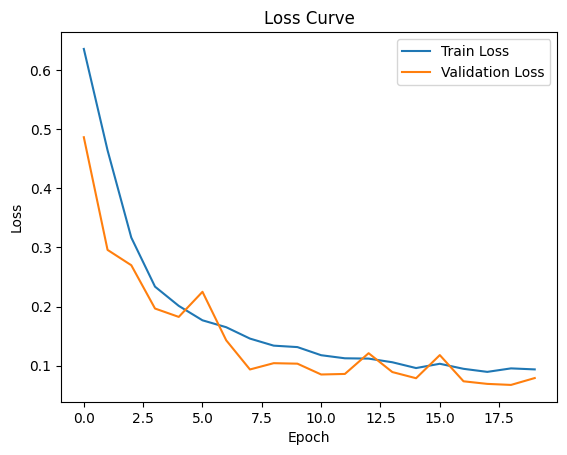

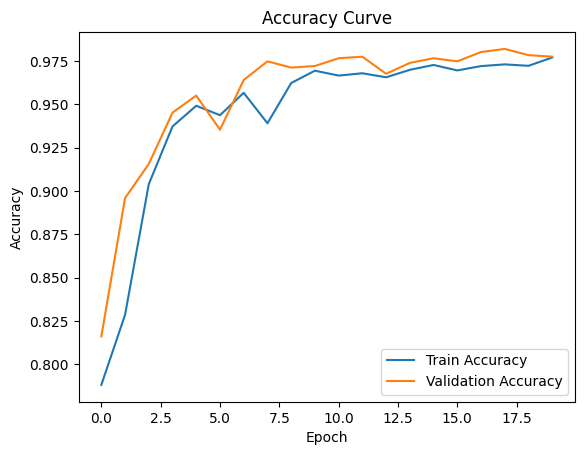

In [24]:
# Deep Layers
# Use more layers to catch higher level semantics
deep_model = MCASpamDetector(len(stoi), hidden_size=64, n_layers=2)
train_rnn_network(deep_model, train_loader, val_loader, num_epochs=20, learning_rate=1e-4)

Epoch 1:Train Loss=0.2646, Train Acc=0.9650,Val Acc=0.9713, Val Loss=0.1134
Epoch 2:Train Loss=0.1021, Train Acc=0.9741,Val Acc=0.9857, Val Loss=0.0655
Epoch 3:Train Loss=0.0642, Train Acc=0.9877,Val Acc=0.9839, Val Loss=0.0632
Epoch 4:Train Loss=0.0478, Train Acc=0.9929,Val Acc=0.9857, Val Loss=0.0597
Epoch 5:Train Loss=0.0280, Train Acc=0.9945,Val Acc=0.9892, Val Loss=0.0499
Epoch 6:Train Loss=0.0233, Train Acc=0.9942,Val Acc=0.9892, Val Loss=0.0477
Epoch 7:Train Loss=0.0229, Train Acc=0.9970,Val Acc=0.9874, Val Loss=0.0505
Epoch 8:Train Loss=0.0093, Train Acc=0.9985,Val Acc=0.9874, Val Loss=0.0569
Epoch 9:Train Loss=0.0082, Train Acc=0.9962,Val Acc=0.9865, Val Loss=0.0652
Epoch 10:Train Loss=0.0196, Train Acc=0.9964,Val Acc=0.9839, Val Loss=0.0634
Epoch 11:Train Loss=0.0070, Train Acc=0.9995,Val Acc=0.9901, Val Loss=0.0573
Epoch 12:Train Loss=0.0026, Train Acc=0.9998,Val Acc=0.9883, Val Loss=0.0649
Epoch 13:Train Loss=0.0123, Train Acc=0.9972,Val Acc=0.9839, Val Loss=0.0696
Epoch 14

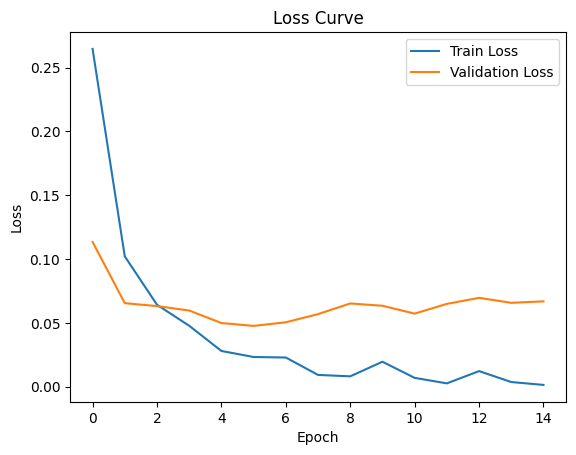

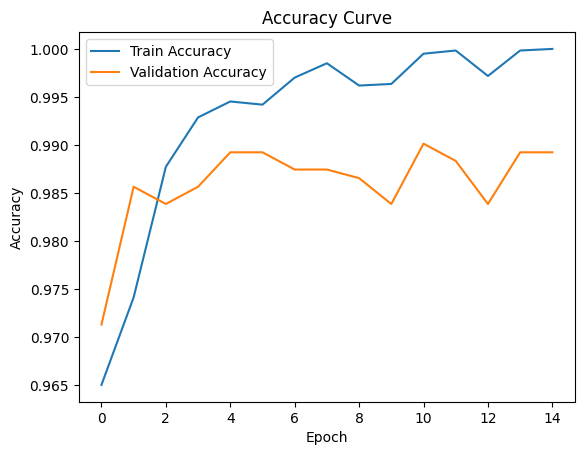

In [26]:
big_lr_maxpool_model = MaxPoolSpamDetector(len(stoi))
train_rnn_network(big_lr_maxpool_model, train_loader, val_loader, num_epochs=15, learning_rate=2e-3)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [28]:
def get_error_rates(model, data):
    model.eval()
    false_positives, false_negatives = 0, 0
    total_negatives, total_positives = 0, 0

    with torch.no_grad():
        for batch_x, batch_y in data:
            logits = model(batch_x)
            preds = (torch.sigmoid(logits) > 0.5).long()
            # For negatives (ham: label 0)
            negatives = (batch_y == 0)
            false_positives += torch.sum((preds == 1) & negatives).item()
            total_negatives += torch.sum(negatives).item()

            # For positives (spam: label 1)
            positives = (batch_y == 1)
            false_negatives += torch.sum((preds == 0) & positives).item()
            total_positives += torch.sum(positives).item()

    fpr = false_positives / total_negatives if total_negatives > 0 else 0
    fnr = false_negatives / total_positives if total_positives > 0 else 0
    return fpr, fnr

fpr, fnr = get_error_rates(big_lr_maxpool_model, val_loader)
print("False Positive Rate on validation set:", fpr)
print("False Negative Rate on validation set:", fnr)


False Positive Rate on validation set: 0.0031088082901554403
False Negative Rate on validation set: 0.06


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:**
- False Positive: The alorithm identify something that is not spam as a spam, this means I could have missed some very important emails in the junk folder.  

- False Negative: The algorithm classify a spam email as not regular email, and I get to see it in the inbox. This is relatively less harmful.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [29]:
get_accuracy(big_lr_maxpool_model, test_loader)

0.97847533632287

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [30]:
fpr, fnr = get_error_rates(big_lr_maxpool_model, test_loader)
print("False Positive Rate on validation set:", fpr)
print("False Negative Rate on validation set:", fnr)

False Positive Rate on validation set: 0.011387163561076604
False Negative Rate on validation set: 0.087248322147651


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [17]:
msg = "machine learning is sooo cool!"

In [39]:
msg_ids = [stoi[char] for char in msg]
msg_tensor = torch.tensor([msg_ids])
logit = model(msg_tensor)
probability = torch.sigmoid(logit).item()
print("Probability that the message is spam:", probability)


Probability that the message is spam: 0.44879457354545593


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer:**
- Based on this lab, I believe it's not a difficult task, since we achieve high accuracy with small number of epochs.

- A simple basline model could be using the frequencies of common words that often appears in a spam message, such as "free", "win" and "prize", to determine if a email is a spam.
